# **Testing with Concept Activation Vectors (TCAV): Практика**

In [29]:
# Основано на туториале https://captum.ai/tutorials/TCAV_Image

**Привет, друзья!**

Продолжая практическое применение теории для concept-based методов перейдем к следующему — TCAV (Testing with Concept Activation Vectors, [статья](https://arxiv.org/pdf/1711.11279.pdf)). В этой практике будем работать с ним, анализируя решения задачи классификации с использованием модели GoogleNet и уже знакомого набора данных — imagenet.

В этой практике вы:
- Поработаете с концептами, как с сущностью библиотеки `captum`
- Познакомитесь с примерами из датасета Broden
- Проанализируете, влияет ли концепт "полосы" на то, что модель определяет на изображении класс зебра

**Приятного кодинга!**

<a href="https://ibb.co/4KZxwnn"><img src="https://i.ibb.co/jbvF9PP/geranimo-ADUi-P4n-Jwds-unsplash.jpg" alt="geranimo-ADUi-P4n-Jwds-unsplash" border="0"></a>


Подробно с тем, как T-CAV работает вы уже ознакомились в теории. Суммируем ещё раз некоторые свойства (которые пригодятся нам при практической оценке).

**По определению:**

- T-CAV $\in [0, ∞]$
- T-CAV $< 0.5$ негативное влияние концепта на класс $k$
- T-CAV $> 0.5$ позитивное влияние концепта на класс $k$
- T-CAV рассчитывается на уровне конкретного слоя
- Объекты с концептами НЕ участвуют в тренировке сети

**Среди свойств написано одно неверное. Найдите его и выберите на степик.**


Как всегда, прежде установим необходимые зависимости.

In [2]:
!pip install captum tcav -q

Также импортируем всё, что нам понадобится для работы.

In [3]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


## Загрузка изображений и определение функций

**1. Изображения**

Для работы и верификации оценок, нам понадобятся:
- набор данных с конкретными концептами
- набор данных со случайными концептами
- набор данных для тестирования

Данные уже заранее выложены на гитхаб. Скачайте и разархивируйте данные, используя друг за другом команды:

```
!wget https://github.com/aiedu-courses/all_datasets/blob/5f087ca9bae13513a84520bf0b3a6ea82bbea163/images/tcav.zip?raw=true -O tcav.zip
```

```
!unzip 'tcav.zip'
```





In [4]:
#!wget https://github.com/SadSabrina/explainable_AI_course/raw/refs/heads/main/HW_module12_concept%20based/tcav.zip -O tcav.zip

#!unzip 'tcav.zip'

После разархивирования, у вас должна появиться папка `tcav`. Проверьте, что все изображения есть в папках `concepts`, `data`.

- `concepts` — мы будем работать с пятью концептами, с тремя конкретными — `striped`, `zigzagged` и `dotted` и двумя случайными.

 Концепты `striped`, `zigzagged` и `dotted` взяты из набора данных [broden](https://netdissect.csail.mit.edu/broden1_224).

 Концепты `random0`, `random1` и `random2` взяты из набора даных imagenet.

- `data` — тестировать и оценивать концепты мы будем на наборе данных `data`, состоящем из зебр.

Альтернативный вариант получения данных также прописан в [туториале](https://github.com/tensorflow/tcav/tree/master/tcav/tcav_examples/image_models/imagenet) от tensorflow.



**2. Функции**

Далее, для обработки данных нам понадобятся:
- функции для загрузки
- функция для предобработки
- датасет, по которому можно итерироваться


1. Функция для предобработки данных.

In [5]:
# Функция для предобработки данных
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


2. Функции загрузки данных.

- `load_image_tensors`— для загрузки изображений в виде тензоров по конкретному пути

**Проанализируйте код функции. Что возвращается, если флаг `transform=False`?**

In [6]:
# Функции для загрузки данных
general_path = '/content/tcav' # укажите пут к папке tcav в виде '.../.../tcav'


def load_image_tensors(class_name, root_path=general_path + '/data/', transform=True):

    path = os.path.join(root_path, class_name) # указываем путь к директории с изображениями
    filenames = glob.glob(path + '/*.jpg') # считываем все изображения с паттерном .jpg

    tensors = []
    for filename in filenames:                    # конвертируем картинки в тензоры
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)

    return tensors


- `get_tensor_from_filename` — функция для загрузки изображения по указанному пути в виде тензора.
- `assemble_concept` — функция для считывания концепций, используя путь к каталогу, в котором они находятся, и создания специального объекта.

**Что возвращает функция `assemble_concept`?**

In [7]:
def get_tensor_from_filename(filename):

    img = Image.open(filename).convert("RGB") # простая функция для обработки изображения
    return transform(img)

def assemble_concept(name, id, concepts_path=general_path + "/concepts"): # Функция для создания объекта концепт

    concept_path = os.path.join(concepts_path, name) + "/" # получаем путь к папке с концептами
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)  # получаем тензоры из каждого объекта в папке
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)


Подготовим объекты на основе каждого концепта.

In [8]:
concepts_path = general_path + '/concepts'

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)


random_0_concept = assemble_concept("random500_0", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("random500_1", 4, concepts_path=concepts_path)

Воскользуемся вспомогательными функциями и визуализируем загруженные концепты.

In [9]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (20, 20))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):

    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*.jpg')

    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=20)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


Output hidden; open in https://colab.research.google.com to view.

## Модель

Как уже было описано, работать будем с моделью GoogleNet. Описание модели можно найти в [оригинальной статье](https://arxiv.org/pdf/1409.4842v1).

In [10]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Рассмотрите архитектуру модели. Выберите верное утверждение на степик.**

# Вычисление T-CAV оценок.

Вспомним математическое определение T-CAV:
$$T_{-}CAV_{c, k, l}=\frac{|x \in X_k: S_{c, k, l}(x) > 0|}{|X_k|}$$

где
- символы $|\cdot|$ означают мощность множества (в нашем случае мощность множества в точности равна количеству объектов в нем)
- оценки $S_{c, k, l}(x)$ отражают производную по направлению наличия концепта "c".

В теории мы с вами ометили, что это похоже на задачу классификации объектов на чувствительные к концепту и не чувствительные. И это действительно так!

Разберемся, как задавать T-CAV. Необходимо указать:
- model — модель, к которой TCAV будет применен,
- layers — список с названиями слоев, на которых будут анализировать изменения активаций
- classifier — классификатор, который будет делить объекты на чувствительные и нет (captum предоставляет возможность задать собственные классификаторы, которые реализованы аналогично доопределенной sklearn.linear_model. Пример вы можете найти [здесь](https://captum.ai/api/_modules/captum/concept/_utils/classifier.html). По умолчанию в captum используется [sklearn.linear_model.SGDClassifier](https://scikit--learn-org.translate.goog/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?_x_tr_sl=en&_x_tr_tl=ru&_x_tr_hl=ru&_x_tr_pto=sc), можно опустить этот параметр)
- layer_attr_method — метод, согласно которому будут вычислены атрибуции
- save_path — также опциональный параметр, если вым зотите сохранять Class Activation Vectors (CAVs) и сами Activation Vectors (AVs).

Мы будем использовать TCAV с классическим классификатором captum на 3х слоях — `['inception4c', 'inception4d', 'inception4e']`. В качестве метода атрибуции, будем использовать Integrated Gradients на уровне слоя.

In [11]:
layers=['inception4c', 'inception4d', 'inception4e']

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


/usr/local/lib/python3.10/dist-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


**Вычисление TCAV.**

**Сформулируем задачу:** оценить важность концепта "stripes" (полосы) для прогнозирования класса зебра.

Согласитесь, одной только оценки важности этого класса нам будет недостаточно — необходимо провести сравнение. Для этого сделаем два экспериментальных набора: ["striped", "random_0"] и ["striped", "random_1"].

С точки зрения теории, наш классификатор будет строить гиперплоскость, котрый отделяет друг от друга концепты из наших наборов.

In [12]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]


Загрузим данные, на которых будем искать полосы. А искать их мы будем на одних из самых полосатых существ в мире — на зебрах!

Данные лежат по пути `/tcav/data/zebra`. Если вы разархивировали все правильно и верно указали пути выше, просто запустите ячейку с кодом ниже. При ошибках проверьте правильность пути.


In [13]:
# Загружаем зебр
zebra_imgs = load_image_tensors('zebra', transform=False)

In [ ]:
print(f'У нас в наличии целых {len(zebra_imgs)} картинок зебр!')

Визуализируем некоторых из них.

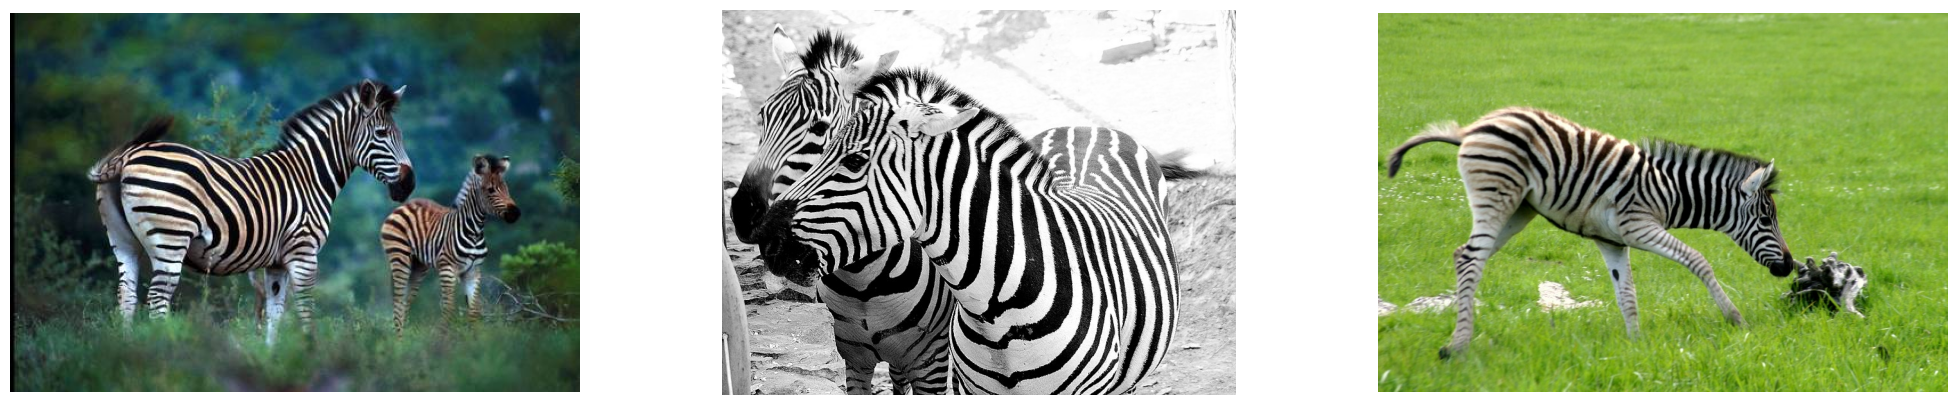

In [15]:
fig, axs = plt.subplots(1, 3, figsize = (25, 5))
axs[0].imshow(zebra_imgs[34])
axs[1].imshow(zebra_imgs[15])
axs[2].imshow(zebra_imgs[7])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')


plt.show()

Переведем зебр в тензоры.

In [16]:
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs])


Прежде чем пойти дальше убедимся, что модель действительно "видит" зебр на всех изображениях. Проверьте это, запустив процесс прогнозирования и выделя предсказанный класс.

**Сколько картинок классифицированы моделью как зебра?**

In [17]:
# Ваш код здесь

И, наконец, запустим процесс интерпретации!

In [19]:
# zebra class index
zebra_ind = 340


tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )
tcav_scores_w_random

/usr/local/lib/python3.10/dist-packages/captum/_utils/models/linear_model/train.py:350: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-3': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.7714, 0.2286]),
                           'magnitude': tensor([ 0.6209, -0.6209])},
                          'inception4d': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 1.4537, -1.4537])},
                          'inception4e': {'sign_count': tensor([0.9714, 0.0286]),
                           'magnitude': tensor([ 0.9119, -0.9119])}}),
             '0-4': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([0.6286, 0.3714]),
                           'magnitude': tensor([ 0.4855, -0.4855])},
                          'inception4d': {'sign_count': tensor([1., 0.]),
                           'magnitude': tensor([ 2.5308, -2.5308])},
                          'inception4e': {'sign_count': tensor([0.6571, 0.3429]),
                

In [20]:
experimental_set_rand

[[Concept(0, 'striped'), Concept(3, 'random500_0')],
 [Concept(0, 'striped'), Concept(4, 'random500_1')]]

И так, мы получили словарь из TCAV оценок. Разберемся, что значит каждая:
- sign count — вычисляются по формуле $\frac{| TCAV > 0 |}{|TCAV|}$

- magnitude score  — вычисляется как $\frac{SUM(ABS(TCAV * (TCAV > 0)))}{SUM(ABS(TCAV))}$

Первая оценка соответствует первому концепту в `experimental_set_rand`, вторая — второму. Как вы можете заметить, корректными в реализации выглядят только sign count scores (magnitude по определению не может быть меньше 0) **(примечание преподавателя)**.

**Пусть мы сравниваем TCAV между двумя наборами концептов и sign count одного из них равна $0.8573$. Чему равна sign count второго? Ответ не округляйте.**

Визуализируем полученные `sign_count` по слоям в певром и втором эксперименте.

In [21]:
# Извлечем данные для отрисовки на графике

# Первый эксперимент

first_experiment_concepts = [experimental_set_rand[0][0].name, experimental_set_rand[0][1].name] # концепты первого эксперимента
first_experiment_layers = list(tcav_scores_w_random['0-3'].keys()) # слои первого эксперимента
first_experiment_scores = [tcav_scores_w_random['0-3'][layer]['sign_count'].numpy() for layer in first_experiment_layers]

In [22]:
# Второй эксперимент

second_experiment_concepts = [experimental_set_rand[1][0].name, experimental_set_rand[1][1].name] # концепты второго эксперимента
second_experiment_layers = list(tcav_scores_w_random['0-4'].keys()) # слои первого эксперимента
second_experiment_scores = [tcav_scores_w_random['0-4'][layer]['sign_count'].numpy() for layer in second_experiment_layers] # оценки второго эксперимента

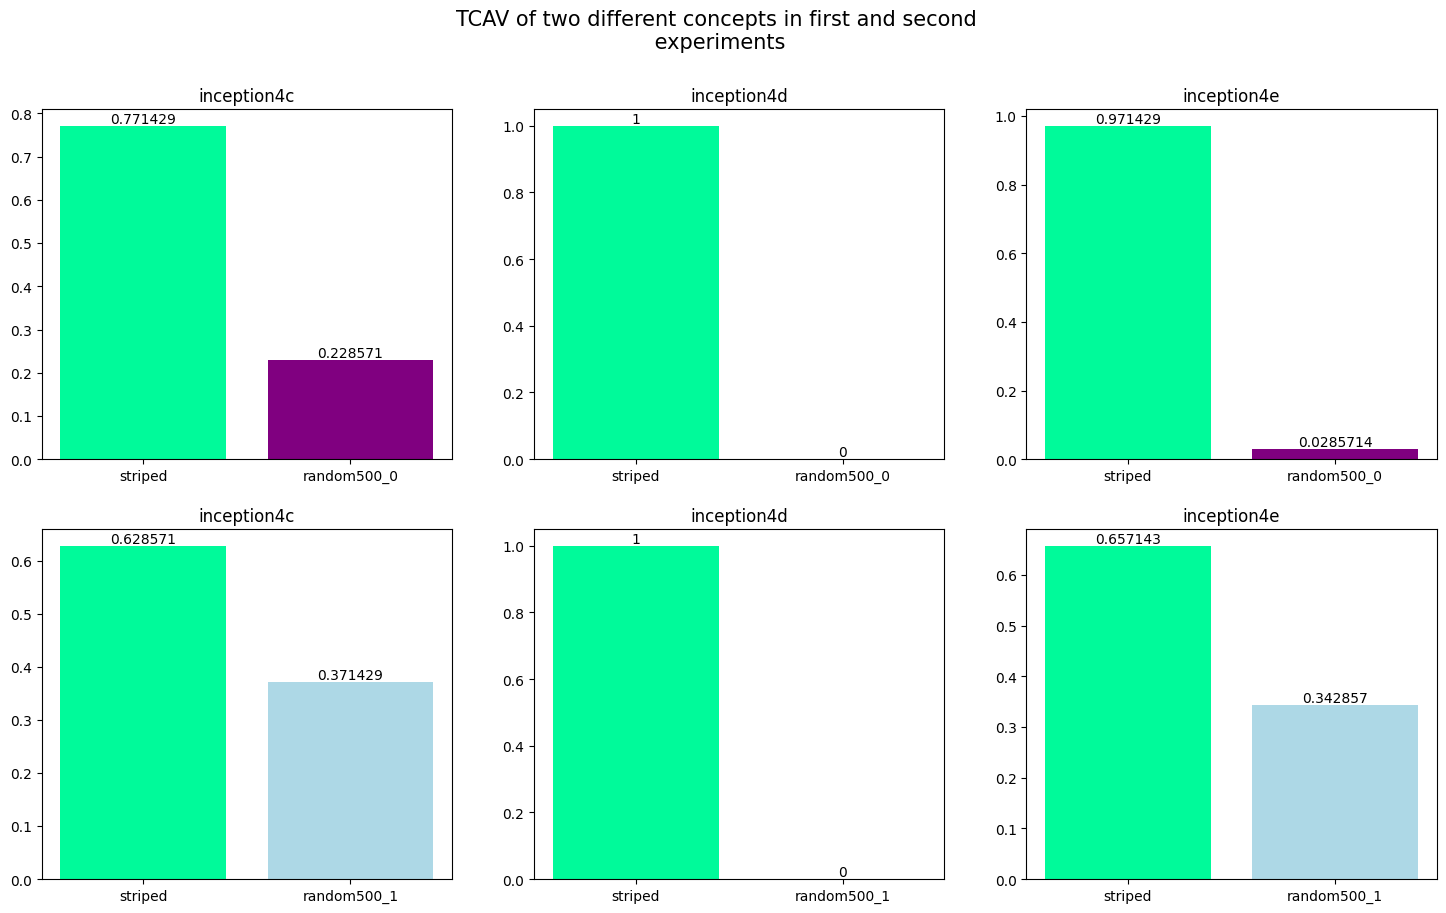

In [23]:
fig, ax = plt.subplots(2, 3, figsize = (18, 10))

for i in range(0, len(first_experiment_layers)):

  ax[0, i].bar(first_experiment_concepts, first_experiment_scores[i], color=['mediumspringgreen', 'purple'])
  ax[0, i].set_title(first_experiment_layers[i])
  ax[0, i].bar_label(ax[0, i].containers[0])

for i in range(0, len(second_experiment_layers)):

  ax[1, i].bar(second_experiment_concepts, second_experiment_scores[i], color=['mediumspringgreen', 'lightblue'])
  ax[1, i].set_title(second_experiment_layers[i])
  ax[1, i].bar_label(ax[1, i].containers[0])


fig.suptitle('TCAV of two different concepts in first and second\n experiments', fontsize=15);

Из графиков вы выше можно заменить, что изображения, которые предсказываются моделью как `зебра`, очень чувствительны к `striped` концепции, в отличие от случайного набора данных. Однако, поскольку случайные картинки равномерно выбираются из набора данных imagenet - они не представляют какую-либо конкретную концепцию, поэтому их можно считать шумом.

Теперь сформулируем эксперимент с конкретными концептами — поставим к нашим полосам точки и зигзаги.

In [24]:
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]] # Экспериментальный набор


In [25]:
tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot, # Запуск процесса интерпретации для новых концептов
                                         target=zebra_ind,
                                         n_steps=5)


In [26]:
tcav_scores_w_zig_dot

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-1-2': defaultdict(None,
                         {'inception4c': {'sign_count': tensor([1.0000, 0.5429, 0.0286]),
                           'magnitude': tensor([ 1.7470, -0.0968, -1.4014])},
                          'inception4d': {'sign_count': tensor([1.0000, 0.1429, 0.0286]),
                           'magnitude': tensor([ 2.1204, -0.4832, -1.0380])},
                          'inception4e': {'sign_count': tensor([1.0000, 0.1429, 0.0000]),
                           'magnitude': tensor([ 1.5237, -0.1541, -1.1403])}})})

In [27]:
# Извлечем данные третьего эксперимента для аналогично — отрисовки на графике

experiment_concepts = [experimental_set_zig_dot[0][0].name, experimental_set_zig_dot[0][1].name, experimental_set_zig_dot[0][2].name]
experiment_layers = list(tcav_scores_w_zig_dot['0-1-2'].keys())
experiment_scores = [tcav_scores_w_zig_dot['0-1-2'][layer]['sign_count'].numpy() for layer in experiment_layers]

experiment_scores

[array([1.        , 0.54285717, 0.02857143], dtype=float32),
 array([1.        , 0.14285715, 0.02857143], dtype=float32),
 array([1.        , 0.14285715, 0.        ], dtype=float32)]

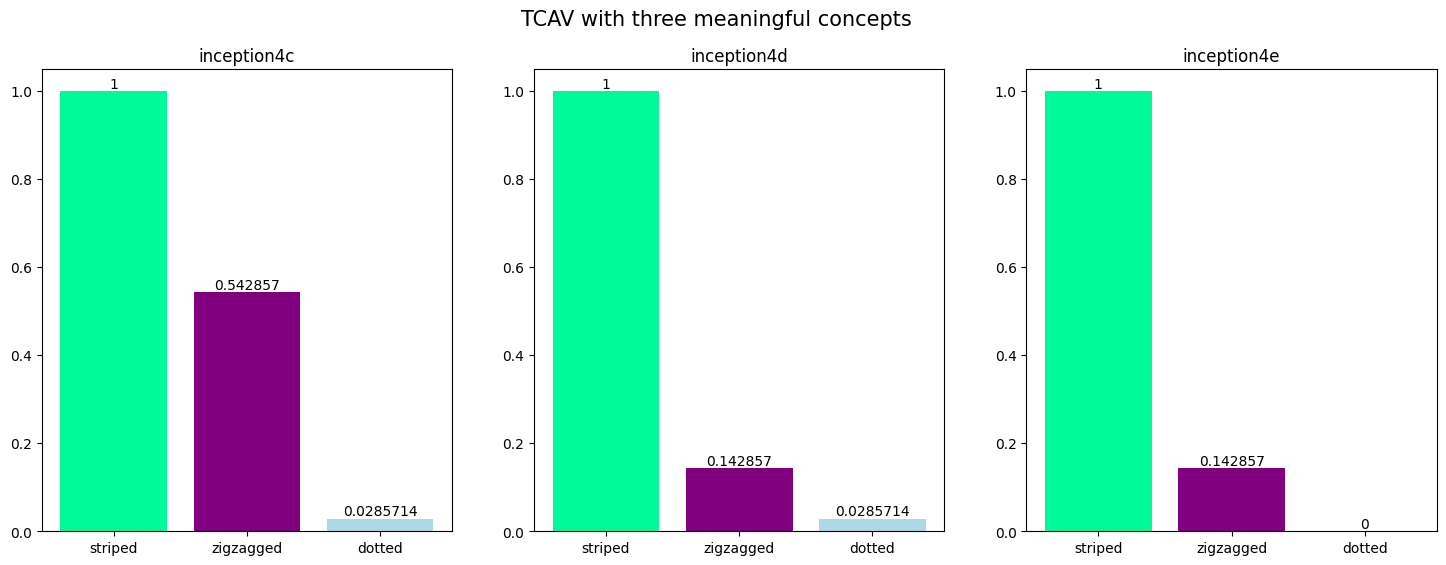

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for i in range(0, len(experiment_layers)):

  ax[i].bar(experiment_concepts, experiment_scores[i], color=['mediumspringgreen', 'purple', 'lightblue'])
  ax[i].set_title(experiment_layers[i])
  ax[i].bar_label(ax[i].containers[0])

fig.suptitle('TCAV with three meaningful concepts', fontsize=15);

1. Как видите, сумма значений несколько превосходит единицу — это нормально, так как мы анализируем сдвиг в сторону наличия концепта для каждого из трёх концептов.
2. Аналогично предыдущему,в этом эксперименте мы также наблюдаем, что концепция `striped` имеет очень высокие оценки TCAV во всех трех слоях по сравнению с `zigzagged` и `dotted`. Это означает, что концепция `striped` является скорее существенной концепцией в предсказании `zebra`.



**На этом всё! Небольшая, но, надееммся полезная практика.**

**Спасибо за работу и внимание!** 😊